In [1]:
# select a GPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
#imports 
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.io
from sklearn.metrics import confusion_matrix
import pandas as pd
from DCASE_plots import plot_confusion_matrix

import librosa
import soundfile as sound
import keras
import tensorflow
print("Librosa version = ",librosa.__version__)
print("Pysoundfile version = ",sound.__version__)
print("keras version = ",keras.__version__)
print("tensorflow version = ",tensorflow.__version__)

Using TensorFlow backend.


Librosa version =  0.6.3
Pysoundfile version =  0.10.2
keras version =  2.2.4
tensorflow version =  1.12.0


In [3]:
#Task 1a dev validation set
ThisPath = '../Task1b/'
File = ThisPath + 'evaluation_setup/fold1_evaluate.csv'
sr = 44100
SampleDuration = 10
NumFreqBins = 128
NumFFTPoints = 2048
HopLength = int(NumFFTPoints/2)
NumTimeBins = int(np.ceil(SampleDuration*sr/HopLength))

In [4]:
#load filenames and labels
dev_test_df = pd.read_csv(File,sep='\t', encoding='ASCII')
Inds_device_a=np.where(dev_test_df['filename'].str.contains("-a.wav")==True)[0]
Inds_device_b=np.where(dev_test_df['filename'].str.contains("-b.wav")==True)[0]
Inds_device_c=np.where(dev_test_df['filename'].str.contains("-c.wav")==True)[0]
Inds_device_bc=np.concatenate((Inds_device_b,Inds_device_c),axis=-1)

wavpaths = dev_test_df['filename'].tolist()
ClassNames = np.unique(dev_test_df['scene_label'])
y_val_labels =  dev_test_df['scene_label'].astype('category').cat.codes.values

#swap codes for 2 and 1 to match the DCASE ordering of classes
a1=np.where(y_val_labels==2)
a2=np.where(y_val_labels==3)
y_val_labels.setflags(write=1)
y_val_labels[a1] = 3
y_val_labels[a2] = 2

In [5]:
#load wav files and get log-mel spectrograms, deltas, and delta-deltas
def deltas(X_in):
    X_out = (X_in[:,:,2:,:]-X_in[:,:,:-2,:])/10.0
    X_out = X_out[:,:,1:-1,:]+(X_in[:,:,4:,:]-X_in[:,:,:-4,:])/5.0
    return X_out

LM_val = np.zeros((len(wavpaths),NumFreqBins,NumTimeBins,1),'float32')
for i in range(len(wavpaths)):
    audio_data,fs = sound.read(ThisPath + wavpaths[i],stop=SampleDuration*sr)
    LM_val[i,:,:,0]= librosa.feature.melspectrogram(audio_data, 
                                       sr=sr,
                                       n_fft=NumFFTPoints,
                                       hop_length=HopLength,
                                       n_mels=NumFreqBins,
                                       fmin=0.0,
                                       fmax=sr/2,
                                       htk=True,
                                       norm=None)

LM_val=np.log(LM_val)
LM_deltas_val = deltas(LM_val)
LM_deltas_deltas_val = deltas(LM_deltas_val)
LM_val = np.concatenate((LM_val[:,:,4:-4,:],LM_deltas_val[:,:,2:-2,:],LM_deltas_deltas_val),axis=-1)

In [6]:
#load and run the model
best_model = keras.models.load_model('DCASE_Task1b_development.h5')
y_pred_val = np.argmax(best_model.predict(LM_val),axis=1)


overall accuracy:  0.7720797720797721
Normalized confusion matrix
per-class accuracy (recall):  [0.64272212 0.86615679 0.81399632 0.76340111 0.91902834 0.5959596
 0.74863388 0.70018622 0.93137255 0.74632353]
per-class precision:  [0.75055188 0.80748663 0.78928571 0.77340824 0.90981964 0.75641026
 0.68046358 0.67504488 0.82465278 0.7645951 ]
mean per-class recall:  0.7727780444773877
mean per-class precision:  0.7731718697888921


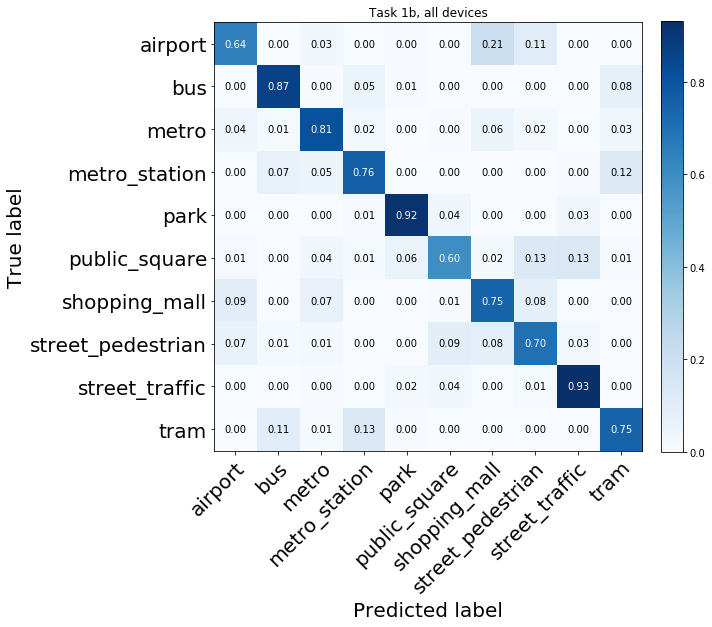

In [7]:
#get metrics for all devices combined
Overall_accuracy = np.sum(y_pred_val==y_val_labels)/LM_val.shape[0]
print("overall accuracy: ", Overall_accuracy)

plot_confusion_matrix(y_val_labels, y_pred_val, ClassNames,normalize=True,title="Task 1b, all devices")

conf_matrix = confusion_matrix(y_val_labels,y_pred_val)
conf_mat_norm_recall = conf_matrix.astype('float32')/conf_matrix.sum(axis=1)[:,np.newaxis]
conf_mat_norm_precision = conf_matrix.astype('float32')/conf_matrix.sum(axis=0)[:,np.newaxis]
recall_by_class = np.diagonal(conf_mat_norm_recall)
precision_by_class = np.diagonal(conf_mat_norm_precision)
mean_recall = np.mean(recall_by_class)
mean_precision = np.mean(precision_by_class)

print("per-class accuracy (recall): ",recall_by_class)
print("per-class precision: ",precision_by_class)
print("mean per-class recall: ",mean_recall)
print("mean per-class precision: ",mean_precision)

overall accuracy:  0.8002389486260454
Normalized confusion matrix
per-class accuracy (recall):  [0.71496437 0.86746988 0.82068966 0.76212471 0.93523316 0.69767442
 0.73922902 0.73892774 0.92537313 0.81422018]
per-class precision:  [0.76010101 0.83526682 0.84       0.859375   0.9025     0.76704545
 0.74770642 0.69977925 0.85517241 0.75052854]
mean per-class recall:  0.8015906277465261
mean per-class precision:  0.8017474912477963


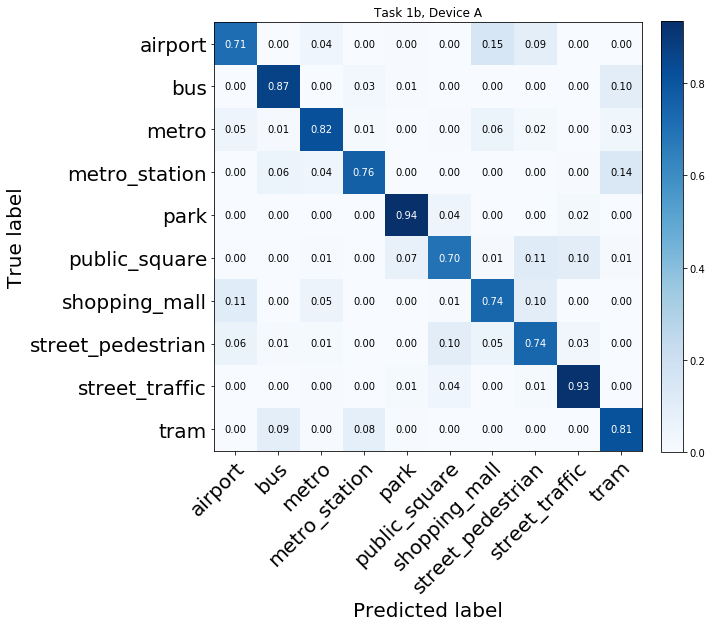

In [8]:
#get metrics for device A only
Overall_accuracy = np.sum(y_pred_val[Inds_device_a]==y_val_labels[Inds_device_a])/len(Inds_device_a)
print("overall accuracy: ", Overall_accuracy)

plot_confusion_matrix(y_val_labels[Inds_device_a], y_pred_val[Inds_device_a], ClassNames,normalize=True,title="Task 1b, Device A")

conf_matrix = confusion_matrix(y_val_labels[Inds_device_a],y_pred_val[Inds_device_a])
conf_mat_norm_recall = conf_matrix.astype('float32')/conf_matrix.sum(axis=1)[:,np.newaxis]
conf_mat_norm_precision = conf_matrix.astype('float32')/conf_matrix.sum(axis=0)[:,np.newaxis]
recall_by_class = np.diagonal(conf_mat_norm_recall)
precision_by_class = np.diagonal(conf_mat_norm_precision)
mean_recall = np.mean(recall_by_class)
mean_precision = np.mean(precision_by_class)

print("per-class accuracy (recall): ",recall_by_class)
print("per-class precision: ",precision_by_class)
print("mean per-class recall: ",mean_recall)
print("mean per-class precision: ",mean_precision)

overall accuracy:  0.6518518518518519
Normalized confusion matrix
per-class accuracy (recall):  [0.25925926 0.81481481 0.81481481 0.77777778 0.88888889 0.25925926
 0.75925926 0.55555556 0.94444444 0.44444444]
per-class precision:  [0.7        0.73333333 0.67692308 0.49411765 0.92307692 0.66666667
 0.46590909 0.54545455 0.77272727 0.85714286]
mean per-class recall:  0.6518518518518519
mean per-class precision:  0.6835351413292589


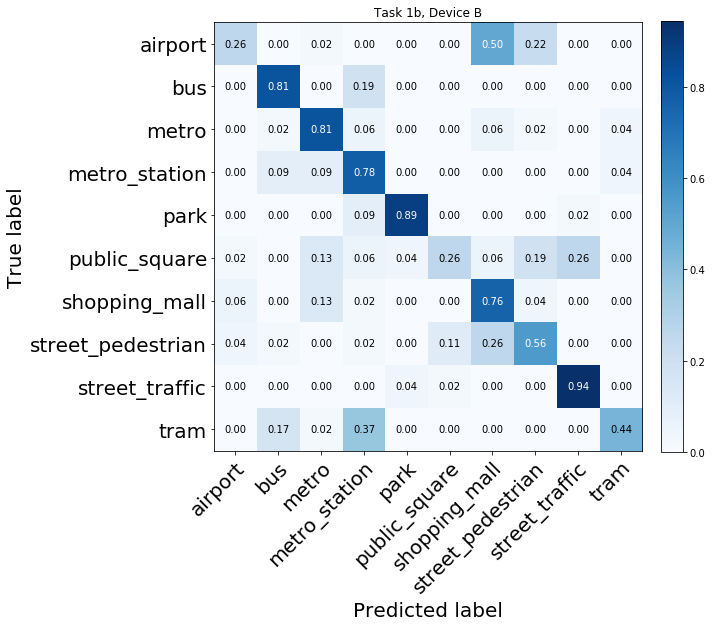

In [9]:
#get metrics for device B only
Overall_accuracy = np.sum(y_pred_val[Inds_device_b]==y_val_labels[Inds_device_b])/len(Inds_device_b)
print("overall accuracy: ", Overall_accuracy)

plot_confusion_matrix(y_val_labels[Inds_device_b], y_pred_val[Inds_device_b], ClassNames,normalize=True,title="Task 1b, Device B")

conf_matrix = confusion_matrix(y_val_labels[Inds_device_b],y_pred_val[Inds_device_b])
conf_mat_norm_recall = conf_matrix.astype('float32')/conf_matrix.sum(axis=1)[:,np.newaxis]
conf_mat_norm_precision = conf_matrix.astype('float32')/conf_matrix.sum(axis=0)[:,np.newaxis]
recall_by_class = np.diagonal(conf_mat_norm_recall)
precision_by_class = np.diagonal(conf_mat_norm_precision)
mean_recall = np.mean(recall_by_class)
mean_precision = np.mean(precision_by_class)

print("per-class accuracy (recall): ",recall_by_class)
print("per-class precision: ",precision_by_class)
print("mean per-class recall: ",mean_recall)
print("mean per-class precision: ",mean_precision)

overall accuracy:  0.674074074074074
Normalized confusion matrix
per-class accuracy (recall):  [0.46296296 0.90740741 0.75925926 0.75925926 0.83333333 0.2037037
 0.81481481 0.53703704 0.96296296 0.5       ]
per-class precision:  [0.67567568 0.7        0.58571429 0.63076923 0.95744681 0.64705882
 0.55       0.59183673 0.69333333 0.9       ]
mean per-class recall:  0.6740740740740742
mean per-class precision:  0.6931834892226454


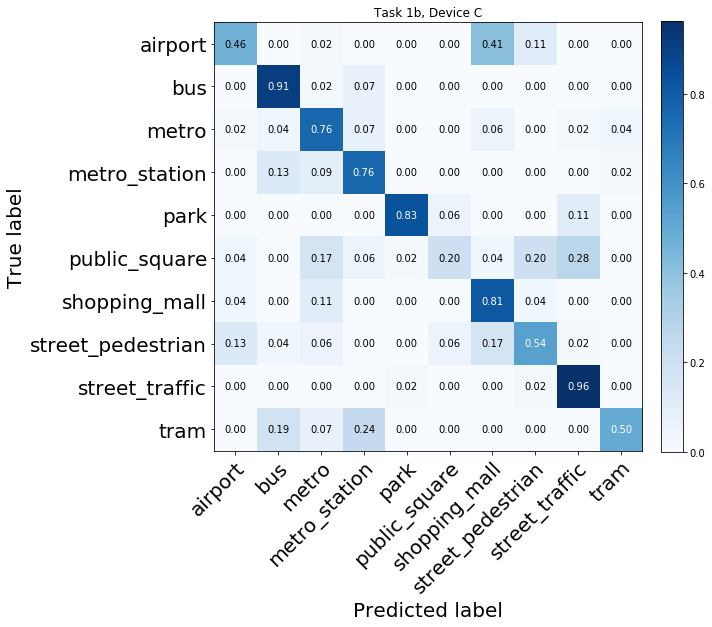

In [10]:
#get metrics for device C only
Overall_accuracy = np.sum(y_pred_val[Inds_device_c]==y_val_labels[Inds_device_c])/len(Inds_device_c)
print("overall accuracy: ", Overall_accuracy)

plot_confusion_matrix(y_val_labels[Inds_device_c], y_pred_val[Inds_device_c], ClassNames,normalize=True,title="Task 1b, Device C")

conf_matrix = confusion_matrix(y_val_labels[Inds_device_c],y_pred_val[Inds_device_c])
conf_mat_norm_recall = conf_matrix.astype('float32')/conf_matrix.sum(axis=1)[:,np.newaxis]
conf_mat_norm_precision = conf_matrix.astype('float32')/conf_matrix.sum(axis=0)[:,np.newaxis]
recall_by_class = np.diagonal(conf_mat_norm_recall)
precision_by_class = np.diagonal(conf_mat_norm_precision)
mean_recall = np.mean(recall_by_class)
mean_precision = np.mean(precision_by_class)

print("per-class accuracy (recall): ",recall_by_class)
print("per-class precision: ",precision_by_class)
print("mean per-class recall: ",mean_recall)
print("mean per-class precision: ",mean_precision)

overall accuracy:  0.662962962962963
Normalized confusion matrix
per-class accuracy (recall):  [0.36111111 0.86111111 0.78703704 0.76851852 0.86111111 0.23148148
 0.78703704 0.5462963  0.9537037  0.47222222]
per-class precision:  [0.68421053 0.71538462 0.62962963 0.55333333 0.93939394 0.65789474
 0.50595238 0.56730769 0.73049645 0.87931034]
mean per-class recall:  0.6629629629629631
mean per-class precision:  0.6862913652887781


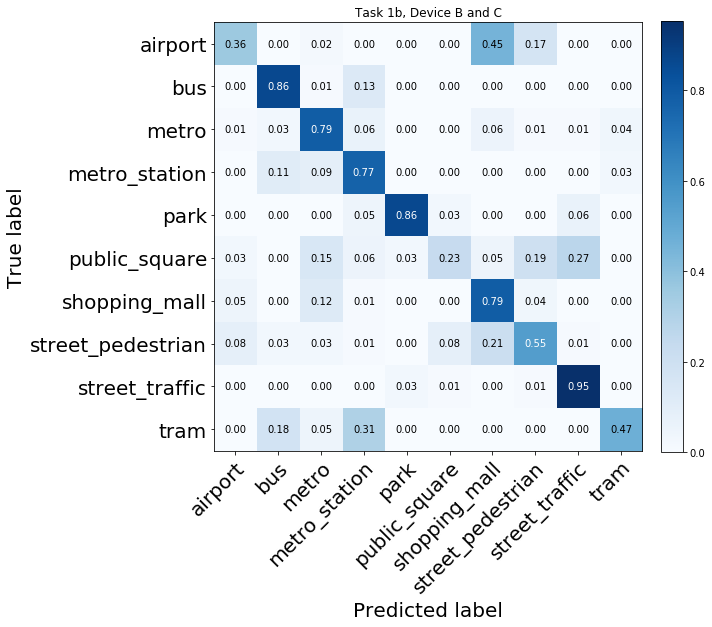

In [11]:
#get metrics for device B and C 
Overall_accuracy = np.sum(y_pred_val[Inds_device_bc]==y_val_labels[Inds_device_bc])/len(Inds_device_bc)
print("overall accuracy: ", Overall_accuracy)

plot_confusion_matrix(y_val_labels[Inds_device_bc], y_pred_val[Inds_device_bc], ClassNames,normalize=True,title="Task 1b, Device B and C")

conf_matrix = confusion_matrix(y_val_labels[Inds_device_bc],y_pred_val[Inds_device_bc])
conf_mat_norm_recall = conf_matrix.astype('float32')/conf_matrix.sum(axis=1)[:,np.newaxis]
conf_mat_norm_precision = conf_matrix.astype('float32')/conf_matrix.sum(axis=0)[:,np.newaxis]
recall_by_class = np.diagonal(conf_mat_norm_recall)
precision_by_class = np.diagonal(conf_mat_norm_precision)
mean_recall = np.mean(recall_by_class)
mean_precision = np.mean(precision_by_class)

print("per-class accuracy (recall): ",recall_by_class)
print("per-class precision: ",precision_by_class)
print("mean per-class recall: ",mean_recall)
print("mean per-class precision: ",mean_precision)